In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import (
    LabelEncoder,
)
from lightgbm import LGBMClassifier
from sklearn.model_selection import (
    GridSearchCV,
    validation_curve,
    cross_validate,
)

pd.set_option("display.max_colwidth", None)  # Increase the width of the output
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

""""
Features:
    FAVC: Frequent consumption of high caloric food,(Yüksek kalorili gıdaların sık tüketilmesi)
    FCVC: Frequency of consumption of vegetables, (Sebze tüketim sıklığı)
    NCP: Number of main meals, (Ana öğün sayısı)
    CAEC: Consumption of food between meals, (Öğün arası yemek tüketimi)
    CH20: Consumption of water daily, (Günlük su tüketimi)
    SCC: Calories consumption monitoring, (Kalori tüketimi izleme)
    FAF: Physical activity frequency, (Fiziksel aktivite sıklığı)
    TUE: Time using technology devices, (Teknoloji cihazları kullanma süresi)
    CALC: Consumption of alcohol. (Alkol tüketimi)
    MTRANS: Transportation used. (Kullanılan ulaşım aracı)
    Gender, (Cinsiyet)
    Age, (Yaş)
    Height and (Boy)
    Weight. (Kilo)
    NObeyesdad: Insufficient Weight, (Yetersiz kilo)F


Targets:
    Insufficient_Weight: label 0
    Normal_Weight: label 1
    Obesity_Type_I: label 2
    Obesity_Type_II: label 3
    Obesity_Type_III: label 4
    Overweight_Level_I: label 5
    Overweight_Level_II: label 6
"""

# importin data from csv files
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")

In [2]:
#############################################
# Exploratory Data Analysis
#############################################


# check_train function for checking the data
def check_train(data_frame, head=5):
    print("##################### Shape #####################")
    print(data_frame.shape)
    print("##################### Types #####################")
    print(data_frame.dtypes)
    print("##################### Head #####################")
    print(data_frame.head(head))
    print("##################### Tail #####################")
    print(data_frame.tail(head))
    print("##################### NA #####################")
    print(data_frame.isnull().sum())
    print("##################### Describe #####################")
    print(data_frame.describe().T)


check_train(train)

##################### Shape #####################
(20758, 18)
##################### Types #####################
id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object
##################### Head #####################
   id  Gender    Age  Height  Weight family_history_with_overweight F

In [3]:
# grab column names for categorical, numerical, categorical but cardinal variables
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """we can use this function for getting categorical, numerical, categorical but cardinal variables names

    Args:
    -------
        dataframe (pandas.DataFrame): all data
        cat_th ([int, floot], optional):

        numeric fakat kategorik olan değişkenler için sınıf eşiği. Defaults to 10.

        car_th ([int, floot], optional):
        katagorik fakat kardinal değişkenler için sınıf eşik değeri. Defaults to 20.

    Returns:
    -------
    cat_cols: List
        kategorik değişken isimleri

    num_cols: List
        numerik değişken isimleri

    cat_but_car: List
        kategorik görünüp aslında kardinal olan değişken isimleri

    Notes:
    -------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat  cat_cols un içinde
        return olan üç liste toplamı toplam değişken sayısına eşittir.

    """

    # cat_cols, cat_but_car
    cat_cols = [
        col
        for col in dataframe.columns
        if str(dataframe[col].dtypes) in ["object", "category", "bool"]
    ]

    num_but_cat = [
        col
        for col in dataframe.columns
        if dataframe[col].nunique() < cat_th
        and dataframe[col].dtypes in ["int64", "float64"]
    ]

    cat_but_car = [
        col
        for col in dataframe.columns
        if dataframe[col].nunique() > car_th
        and str(dataframe[col].dtypes) in ["object", "category"]
    ]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [
        col
        for col in dataframe.columns
        if dataframe[col].dtypes in ["int64", "float64"] and col not in cat_cols
    ]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(train)

Observations: 20758
Variables: 18
cat_cols: 9
num_cols: 9
cat_but_car: 0
num_but_cat: 0


In [4]:
# drop the id column for outlier detection
num_cols = [col for col in num_cols if "id" not in col]

##################### Gender #####################
        Gender  Ratio
Female   10422 50.207
Male     10336 49.793


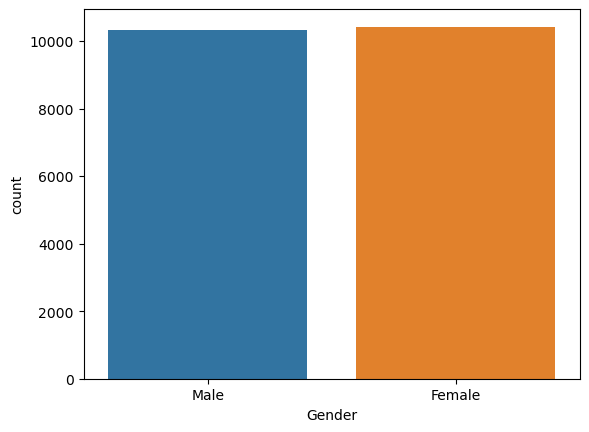

##################### family_history_with_overweight #####################
     family_history_with_overweight  Ratio
yes                           17014 81.964
no                             3744 18.036


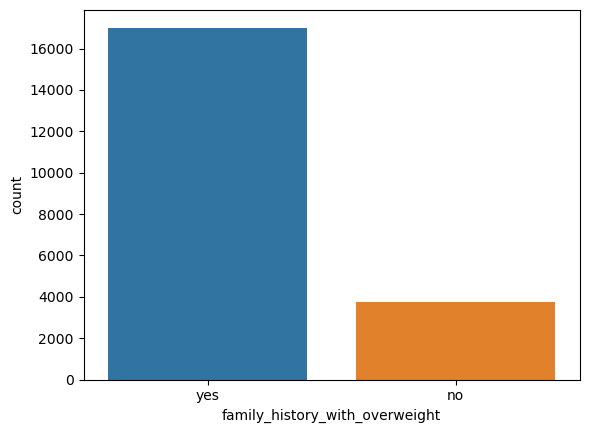

##################### FAVC #####################
      FAVC  Ratio
yes  18982 91.444
no    1776  8.556


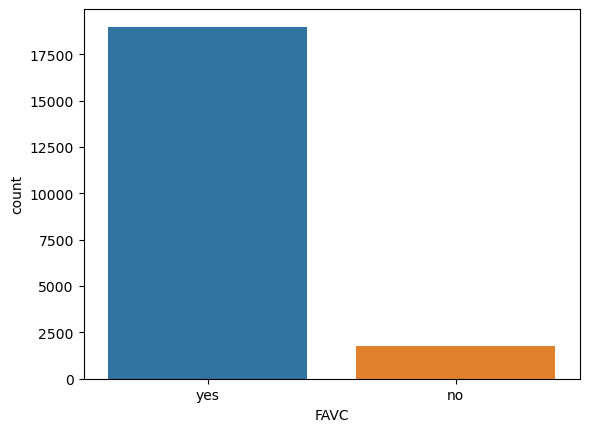

##################### CAEC #####################
             CAEC  Ratio
Sometimes   17529 84.445
Frequently   2472 11.909
Always        478  2.303
no            279  1.344


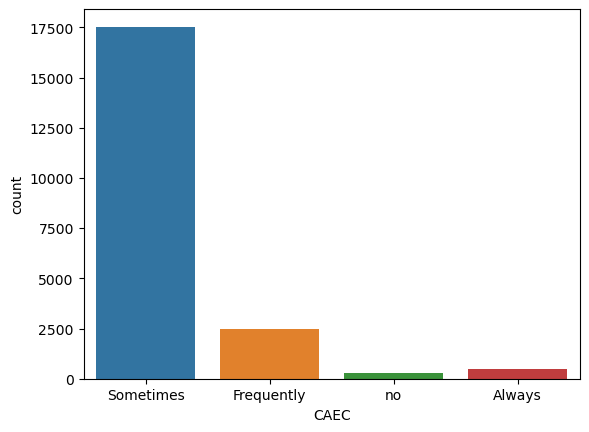

##################### SMOKE #####################
     SMOKE  Ratio
no   20513 98.820
yes    245  1.180


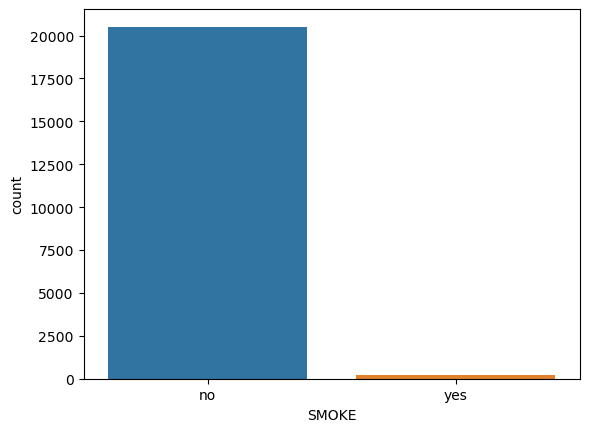

##################### SCC #####################
       SCC  Ratio
no   20071 96.690
yes    687  3.310


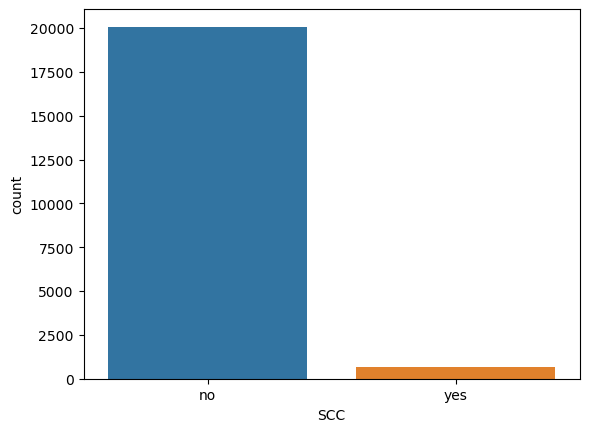

##################### CALC #####################
             CALC  Ratio
Sometimes   15066 72.579
no           5163 24.872
Frequently    529  2.548


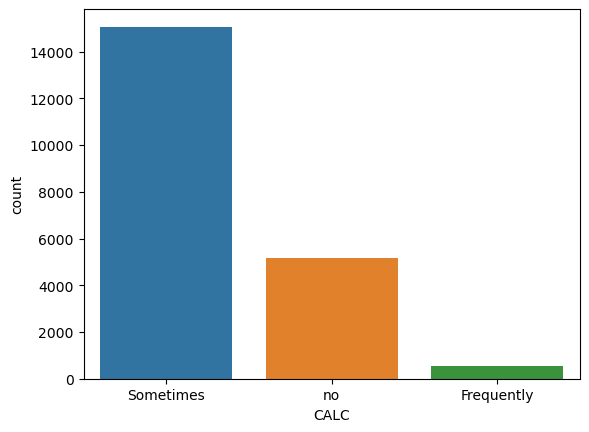

##################### MTRANS #####################
                       MTRANS  Ratio
Public_Transportation   16687 80.388
Automobile               3534 17.025
Walking                   467  2.250
Motorbike                  38  0.183
Bike                       32  0.154


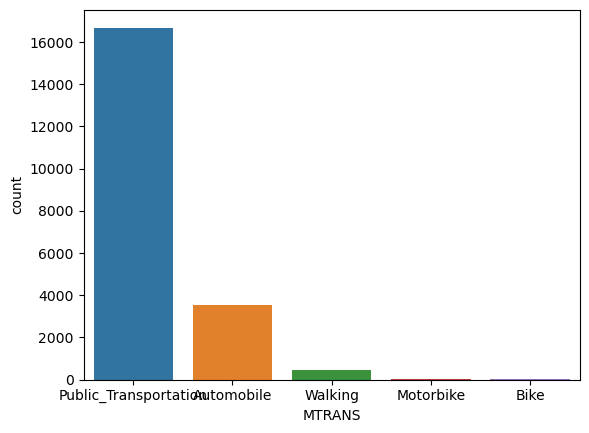

##################### NObeyesdad #####################
                     NObeyesdad  Ratio
Obesity_Type_III           4046 19.491
Obesity_Type_II            3248 15.647
Normal_Weight              3082 14.847
Obesity_Type_I             2910 14.019
Insufficient_Weight        2523 12.154
Overweight_Level_II        2522 12.150
Overweight_Level_I         2427 11.692


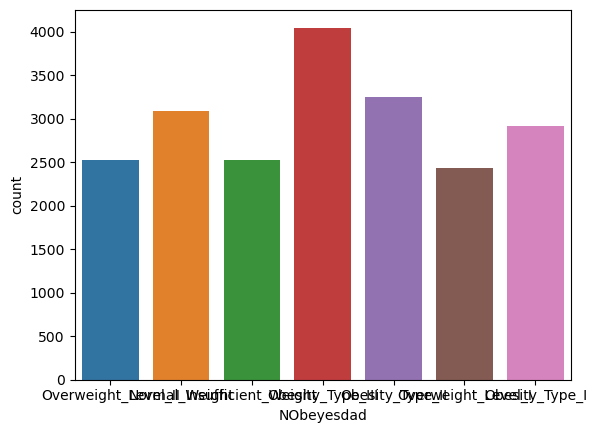

In [5]:
# Summary of categorical variabes
def cat_summary(data_frame, colm_name, plot=False):
    print(
        pd.DataFrame(
            {
                colm_name: data_frame[colm_name].value_counts(),
                "Ratio": 100 * data_frame[colm_name].value_counts() / len(data_frame),
            }
        )
    )

    if plot:
        sns.countplot(x=data_frame[colm_name], data=data_frame)
        plt.show(block=True)


for col in cat_cols:
    print(f"##################### {col} #####################")
    # bool type columns are converted to int type
    if train[col].dtypes == "bool":
        train[col] = train[col].astype(int)
        cat_summary(train, col, plot=True)
    else:
        cat_summary(train, col, plot=True)

########################### Age ###########################
count   20758.000
mean       23.842
std         5.688
min        14.000
5%         17.990
10%        18.000
20%        19.000
30%        21.000
40%        21.233
50%        22.815
60%        23.801
70%        25.960
80%        26.000
90%        31.386
95%        35.460
99%        41.000
max        61.000
Name: Age, dtype: float64


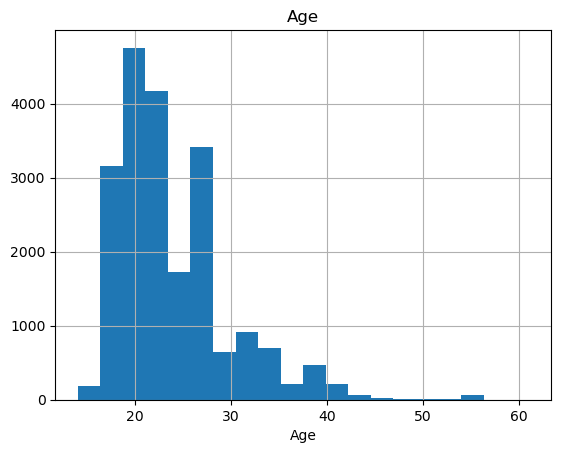

########################### Height ###########################
count   20758.000
mean        1.700
std         0.087
min         1.450
5%          1.559
10%         1.600
20%         1.623
30%         1.643
40%         1.670
50%         1.700
60%         1.726
70%         1.750
80%         1.779
90%         1.819
95%         1.846
99%         1.889
max         1.976
Name: Height, dtype: float64


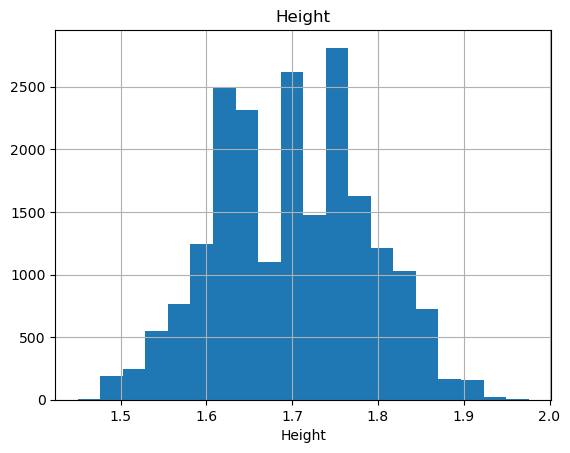

########################### Weight ###########################
count   20758.000
mean       87.888
std        26.379
min        39.000
5%         49.000
10%        51.133
20%        60.000
30%        70.000
40%        79.713
50%        84.065
60%        97.813
70%       106.035
80%       112.095
90%       120.997
95%       132.116
99%       137.855
max       165.057
Name: Weight, dtype: float64


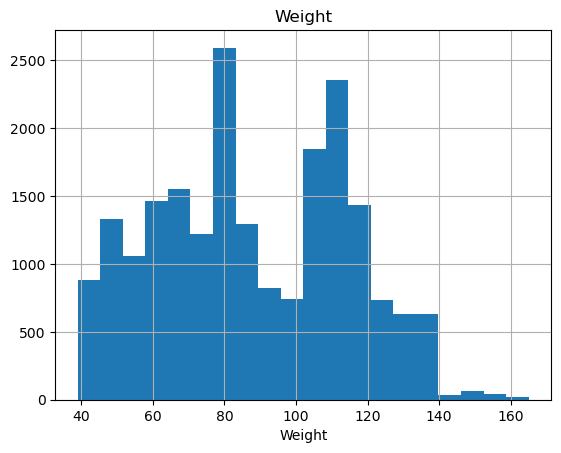

########################### FCVC ###########################
count   20758.000
mean        2.446
std         0.533
min         1.000
5%          1.827
10%         2.000
20%         2.000
30%         2.000
40%         2.000
50%         2.394
60%         2.939
70%         3.000
80%         3.000
90%         3.000
95%         3.000
99%         3.000
max         3.000
Name: FCVC, dtype: float64


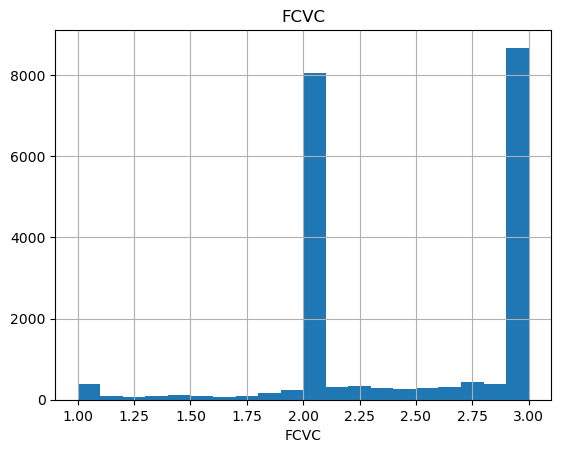

########################### NCP ###########################
count   20758.000
mean        2.761
std         0.705
min         1.000
5%          1.000
10%         1.079
20%         2.918
30%         3.000
40%         3.000
50%         3.000
60%         3.000
70%         3.000
80%         3.000
90%         3.000
95%         3.521
99%         4.000
max         4.000
Name: NCP, dtype: float64


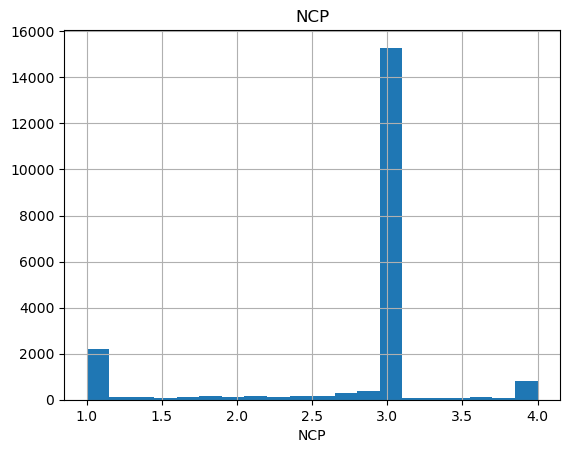

########################### CH2O ###########################
count   20758.000
mean        2.029
std         0.608
min         1.000
5%          1.000
10%         1.000
20%         1.482
30%         2.000
40%         2.000
50%         2.000
60%         2.000
70%         2.320
80%         2.653
90%         2.868
95%         3.000
99%         3.000
max         3.000
Name: CH2O, dtype: float64


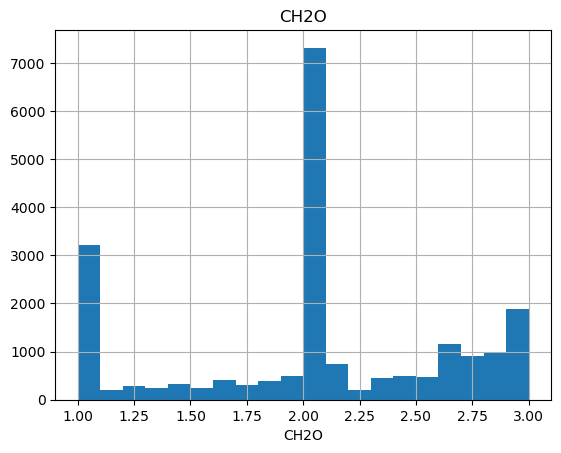

########################### FAF ###########################
count   20758.000
mean        0.982
std         0.838
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.171
40%         0.890
50%         1.000
60%         1.000
70%         1.350
80%         1.931
90%         2.000
95%         2.546
99%         3.000
max         3.000
Name: FAF, dtype: float64


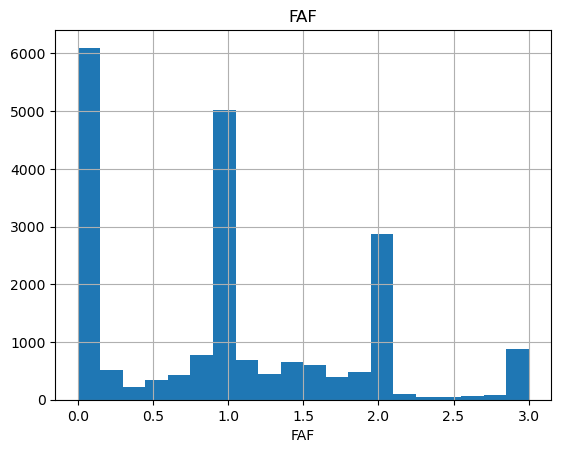

########################### TUE ###########################
count   20758.000
mean        0.617
std         0.602
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.225
50%         0.574
60%         0.880
70%         1.000
80%         1.000
90%         1.444
95%         2.000
99%         2.000
max         2.000
Name: TUE, dtype: float64


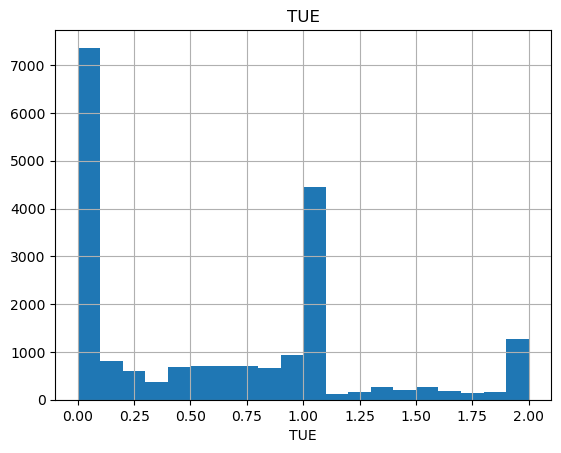

In [6]:
# Summary of numerical variables
def num_summary(dataframe, num_cols, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[num_cols].describe(quantiles).T)

    if plot:
        dataframe[num_cols].hist(bins=20)
        plt.xlabel(num_cols)
        plt.title(num_cols)
        plt.show(block=True)


for col in num_cols:
    # wrrite the variable name
    print(f"########################### {col} ###########################")
    num_summary(train, col, plot=True)

In [7]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443,1.700,81.670,yes,yes,2.000,2.983,Sometimes,no,2.764,no,0.000,0.976,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000,1.560,57.000,yes,yes,2.000,3.000,Frequently,no,2.000,no,1.000,1.000,no,Automobile,Normal_Weight
2,2,Female,18.000,1.711,50.166,yes,yes,1.881,1.412,Sometimes,no,1.910,no,0.866,1.674,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.953,1.711,131.275,yes,yes,3.000,3.000,Sometimes,no,1.674,no,1.468,0.780,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641,1.914,93.798,yes,yes,2.680,1.971,Sometimes,no,1.980,no,1.968,0.932,Sometimes,Public_Transportation,Overweight_Level_II


In [8]:
# label encoding for NObeyesdad column for visualization
label_encoder = LabelEncoder()
train["NObeyesdad_encoded"] = label_encoder.fit_transform(train["NObeyesdad"])

##################### Gender #####################
       NObeyesdad_encoded                   
                    count  mean median   std
Gender                                      
Male                10336 3.080  3.000 1.885
Female              10422 2.904  4.000 1.897


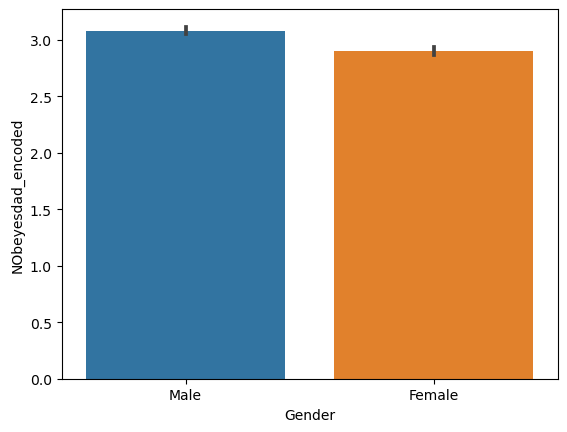

##################### family_history_with_overweight #####################
                               NObeyesdad_encoded                   
                                            count  mean median   std
family_history_with_overweight                                      
yes                                         17014 3.277  3.000 1.716
no                                           3744 1.695  1.000 2.108


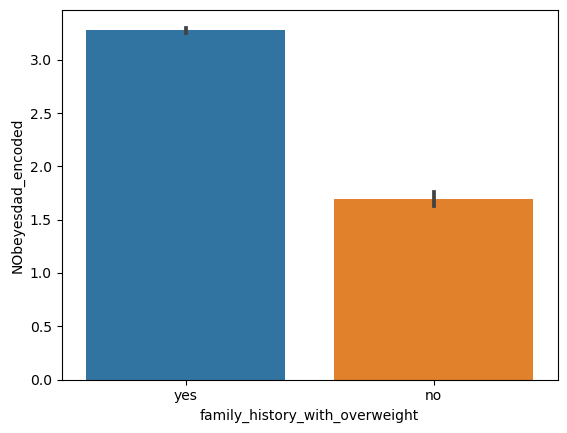

##################### FAVC #####################
     NObeyesdad_encoded                   
                  count  mean median   std
FAVC                                      
yes               18982 2.997  3.000 1.825
no                 1776 2.928  2.000 2.505


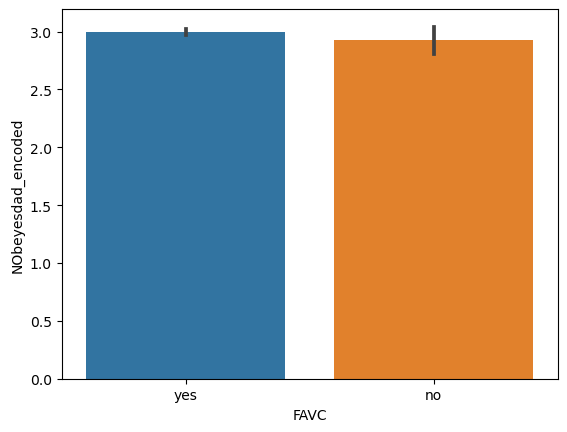

##################### CAEC #####################
           NObeyesdad_encoded                   
                        count  mean median   std
CAEC                                            
no                        279 4.262  5.000 1.598
Sometimes               17529 3.222  3.000 1.749
Always                    478 1.956  1.000 1.771
Frequently               2472 1.412  1.000 2.065


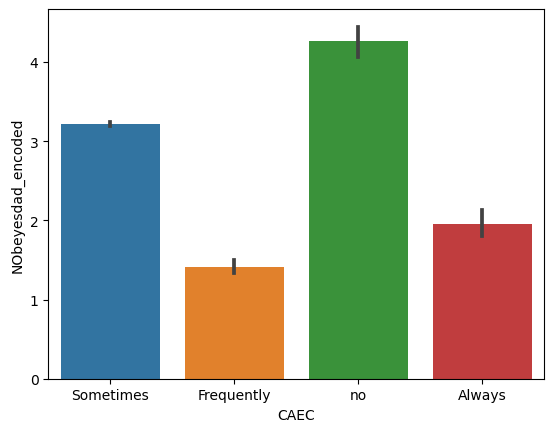

##################### SMOKE #####################
      NObeyesdad_encoded                   
                   count  mean median   std
SMOKE                                      
no                 20513 2.992  3.000 1.897
yes                  245 2.967  3.000 1.568


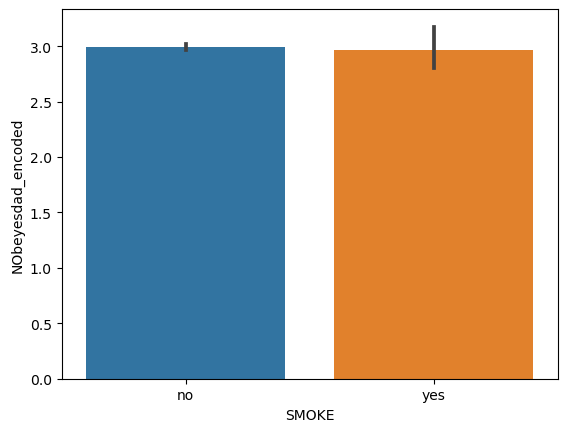

##################### SCC #####################
    NObeyesdad_encoded                   
                 count  mean median   std
SCC                                      
no               20071 3.014  3.000 1.873
yes                687 2.325  1.000 2.305


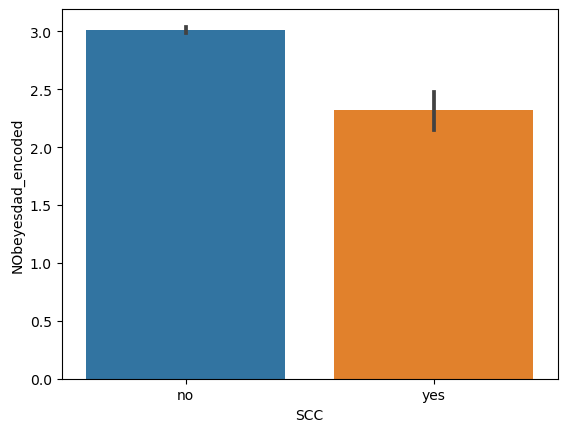

##################### CALC #####################
           NObeyesdad_encoded                   
                        count  mean median   std
CALC                                            
Frequently                529 4.304  5.000 2.016
Sometimes               15066 3.107  3.000 1.766
no                       5163 2.518  2.000 2.110


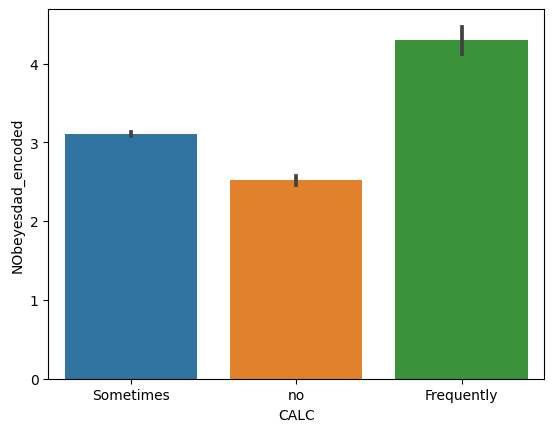

##################### MTRANS #####################
                      NObeyesdad_encoded                   
                                   count  mean median   std
MTRANS                                                     
Automobile                          3534 3.311  3.000 1.924
Public_Transportation              16687 2.934  3.000 1.865
Bike                                  32 2.812  1.500 2.177
Walking                              467 2.685  1.000 2.322
Motorbike                             38 2.289  1.000 1.972


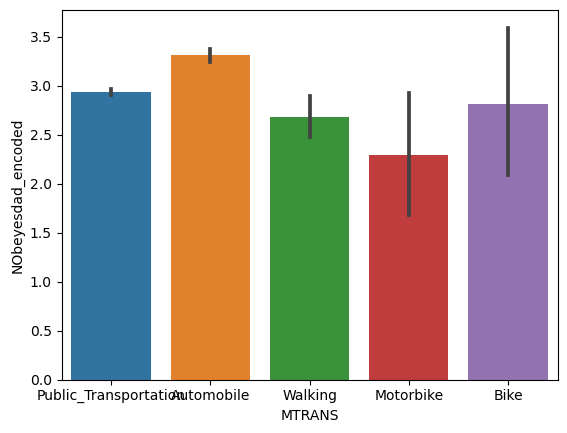

##################### NObeyesdad #####################
                    NObeyesdad_encoded                   
                                 count  mean median   std
NObeyesdad                                               
Overweight_Level_II               2522 6.000  6.000 0.000
Overweight_Level_I                2427 5.000  5.000 0.000
Obesity_Type_III                  4046 4.000  4.000 0.000
Obesity_Type_II                   3248 3.000  3.000 0.000
Obesity_Type_I                    2910 2.000  2.000 0.000
Normal_Weight                     3082 1.000  1.000 0.000
Insufficient_Weight               2523 0.000  0.000 0.000


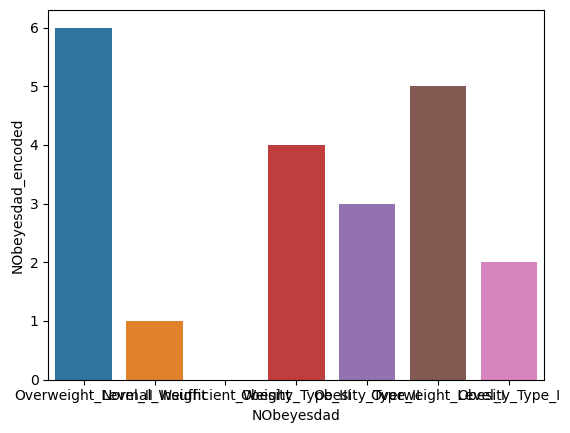

In [9]:
# target variable analysis for categorical variables
def target_summary_with_cat(dataframe, target, categorical_col, graph=False):
    # show percentage(?/100) of target variable for categorical variables
    print(
        dataframe.groupby(categorical_col)
        .agg({target: ["count", "mean", "median", "std"]})
        .sort_values(by=(target, "mean"), ascending=False)
    )

    # barplot for categorical variables
    if graph:
        sns.barplot(data=dataframe, x=categorical_col, y=target)
        plt.show(block=True)


for col in cat_cols:
    print(f"##################### {col} #####################")
    target_summary_with_cat(train, "NObeyesdad_encoded", col, graph=True)

##################### Age #####################
                     Age                    
                   count   mean median   std
NObeyesdad_encoded                          
3                   3248 27.707 26.699 4.275
6                   2522 26.032 23.000 7.776
2                   2910 25.024 22.852 7.240
4                   4046 24.127 25.957 2.576
5                   2427 23.045 21.000 5.935
1                   3082 20.801 21.000 3.420
0                   2523 19.337 19.000 2.249


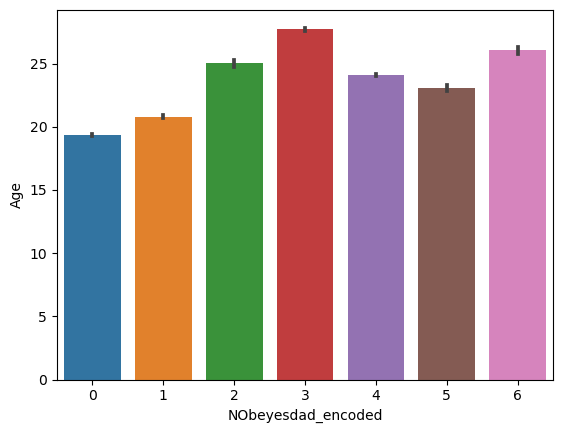

##################### Height #####################
                   Height                   
                    count  mean median   std
NObeyesdad_encoded                          
3                    3248 1.783  1.774 0.064
6                    2522 1.706  1.700 0.074
2                    2910 1.694  1.695 0.090
5                    2427 1.687  1.700 0.085
0                    2523 1.684  1.700 0.096
4                    4046 1.676  1.643 0.059
1                    3082 1.671  1.660 0.087


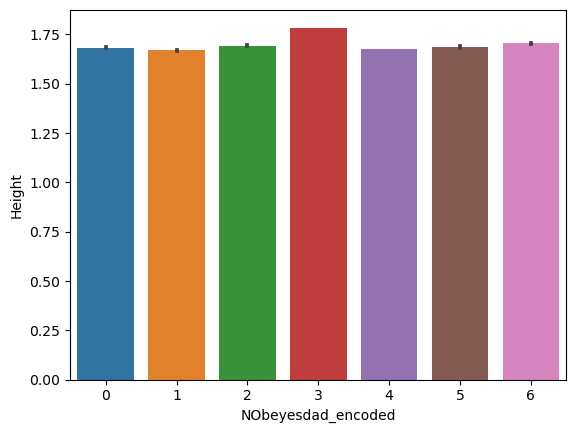

##################### Weight #####################
                   Weight                       
                    count    mean  median    std
NObeyesdad_encoded                              
4                    4046 117.697 111.914 13.341
3                    3248 115.996 118.333  7.803
2                    2910  92.371  90.116 11.425
6                    2522  82.086  81.627  7.403
5                    2427  74.228  75.000  7.997
1                    3082  61.533  60.000  8.525
0                    2523  49.861  50.000  5.735


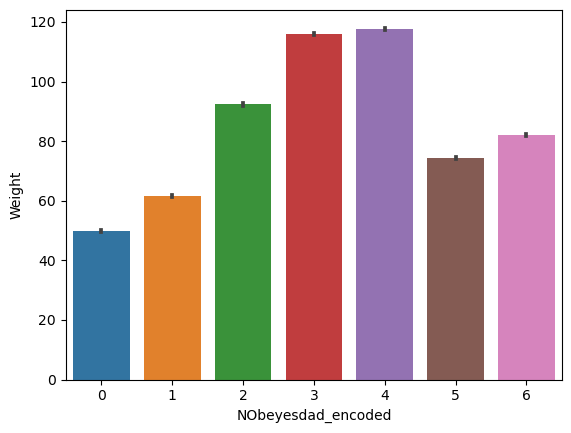

##################### FCVC #####################
                    FCVC                   
                   count  mean median   std
NObeyesdad_encoded                         
4                   4046 3.000  3.000 0.000
0                   2523 2.480  2.766 0.584
3                   3248 2.425  2.499 0.490
1                   3082 2.372  2.000 0.544
5                   2427 2.257  2.000 0.489
6                   2522 2.224  2.000 0.444
2                   2910 2.097  2.000 0.391


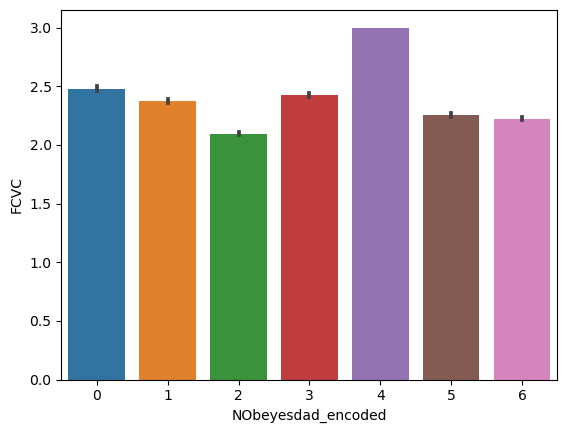

##################### NCP #####################
                     NCP                   
                   count  mean median   std
NObeyesdad_encoded                         
4                   4046 3.000  3.000 0.003
0                   2523 2.920  3.000 0.865
1                   3082 2.890  3.000 0.663
3                   3248 2.798  3.000 0.492
6                   2522 2.594  3.000 0.745
5                   2427 2.528  3.000 0.922
2                   2910 2.455  3.000 0.831


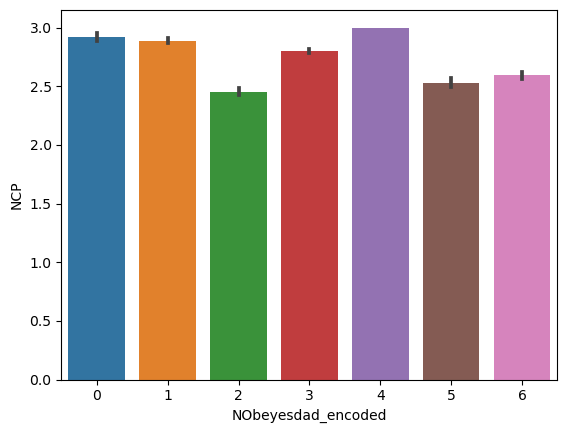

##################### CH2O #####################
                    CH2O                   
                   count  mean median   std
NObeyesdad_encoded                         
4                   4046 2.332  2.618 0.578
2                   2910 2.130  2.000 0.629
5                   2427 2.069  2.000 0.625
6                   2522 2.004  2.000 0.537
3                   3248 1.985  2.015 0.552
1                   3082 1.806  2.000 0.557
0                   2523 1.744  2.000 0.560


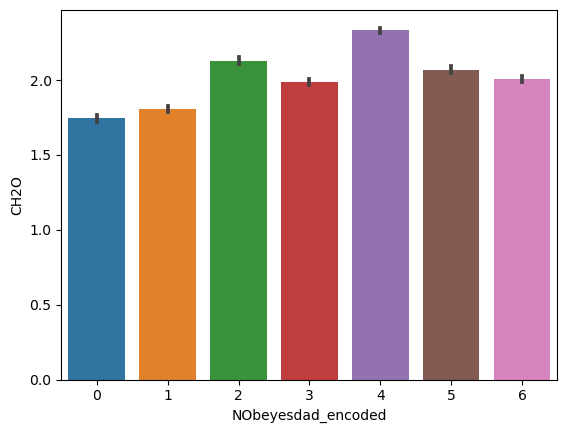

##################### FAF #####################
                     FAF                   
                   count  mean median   std
NObeyesdad_encoded                         
0                   2523 1.202  1.000 0.845
1                   3082 1.190  1.000 0.906
5                   2427 1.135  1.000 0.862
6                   2522 1.061  1.000 0.829
3                   3248 1.030  1.000 0.546
2                   2910 0.923  1.000 0.927
4                   4046 0.549  0.035 0.729


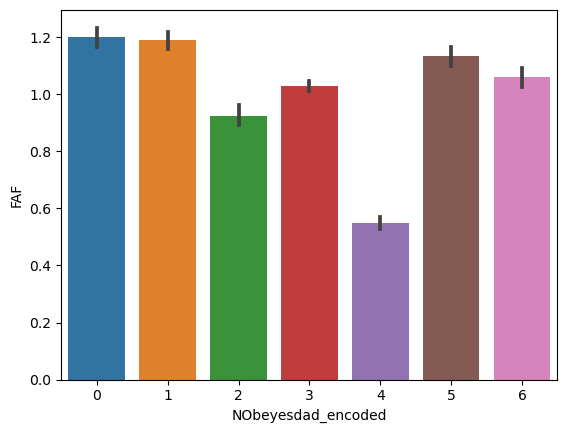

##################### TUE #####################
                     TUE                   
                   count  mean median   std
NObeyesdad_encoded                         
0                   2523 0.803  1.000 0.659
2                   2910 0.739  0.666 0.735
6                   2522 0.698  0.930 0.641
1                   3082 0.630  1.000 0.620
5                   2427 0.557  0.134 0.661
4                   4046 0.549  0.562 0.295
3                   3248 0.416  0.092 0.533


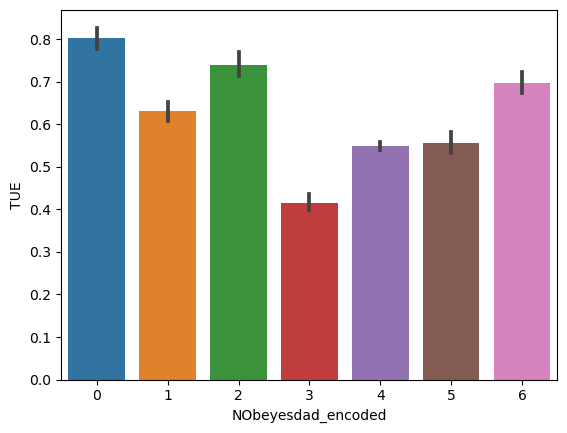

In [10]:
# target variable analysis for numerical variables
def target_summary_with_num(dataframe, target, numerical_col, graph=False):
    # show percentage(?/100) of target variable for numerical variables
    print(
        dataframe.groupby(target)
        .agg({numerical_col: ["count", "mean", "median", "std"]})
        .sort_values(by=(numerical_col, "mean"), ascending=False)
    )

    # barplot for numerical variables
    if graph:
        sns.barplot(data=dataframe, x=target, y=numerical_col)
        plt.show(block=True)


for col in num_cols:
    print(f"##################### {col} #####################")
    target_summary_with_num(train, "NObeyesdad_encoded", col, graph=True)

<ipython-input-11-cfb3400eb97c>:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataframe.corr().abs()


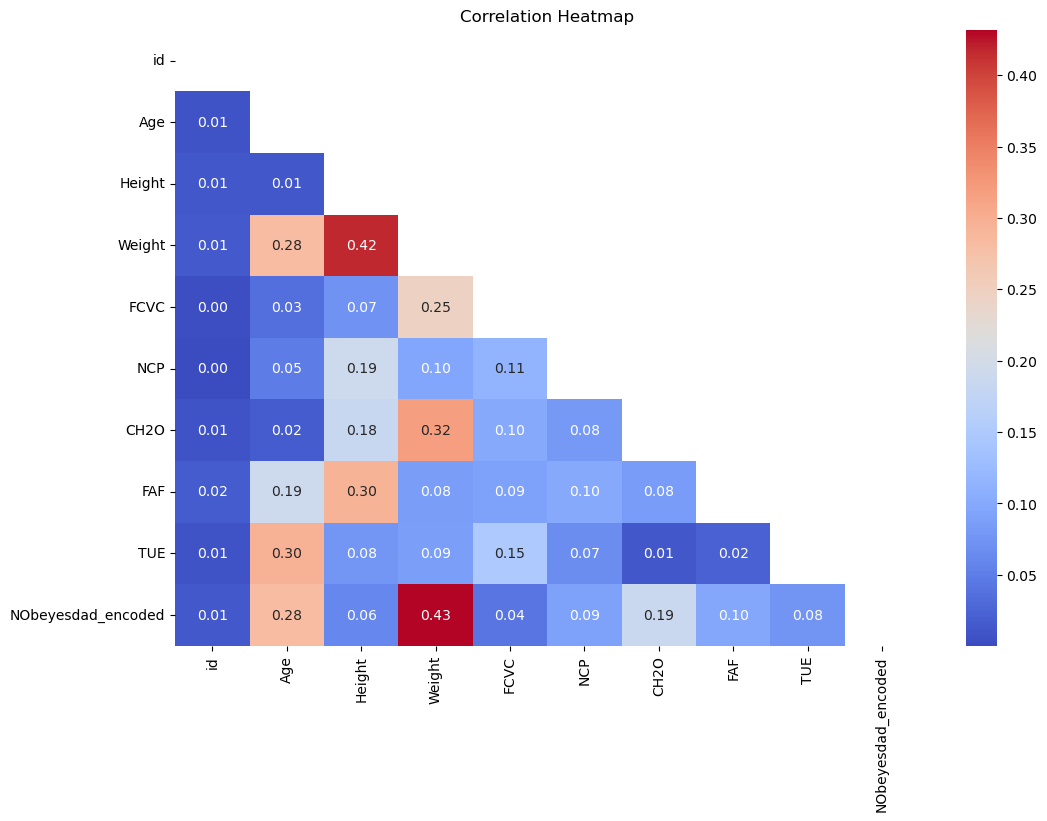

In [11]:
# Correlation matrix analysis for numerical variables
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    # Select only numeric columns
    dataframe = dataframe.select_dtypes(include=[np.number])

    # Calculate the correlation matrix
    corr_matrix = dataframe.corr().abs()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Create a series with the correlation coefficients
    high_corr = corr_matrix.mask(mask).stack().sort_values(ascending=False)

    # Filter the series to include only the correlations above the threshold
    high_corr = high_corr[high_corr > corr_th]

    # Convert the series index to a list of tuples
    high_corr.index = high_corr.index.to_list()

    # Create a list of the column names
    high_corr_list = [x[0] for x in high_corr.index]

    # Display the heatmap
    if plot:
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.show()

    return high_corr_list

high_corr_list = high_correlated_cols(train, plot=True, corr_th=0.90)


high_corr_list = high_correlated_cols(train, plot=True, corr_th=0.90)

In [12]:
# drop highly correlated columns
train = train.drop(high_corr_list, axis=1)

In [13]:
train.shape

(20758, 19)

In [14]:
#############################################
# Outliers
#############################################


# outlier_thresholds function for finding the limits of outliers
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


# check_outlier function for checking the outliers
def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[
        (dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)
    ].any(axis=None):
        return True
    else:
        return False

In [15]:
cat_cols, num_cols, cat_but_car = grab_col_names(train)

Observations: 20758
Variables: 19
cat_cols: 9
num_cols: 9
cat_but_car: 0
num_but_cat: 0


In [16]:
# drop id from num cols
num_cols = [col for col in num_cols if "id" not in col]

In [17]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,NObeyesdad_encoded
0,0,Male,24.443,1.700,81.670,yes,yes,2.000,2.983,Sometimes,no,2.764,no,0.000,0.976,Sometimes,Public_Transportation,Overweight_Level_II,6
1,1,Female,18.000,1.560,57.000,yes,yes,2.000,3.000,Frequently,no,2.000,no,1.000,1.000,no,Automobile,Normal_Weight,1
2,2,Female,18.000,1.711,50.166,yes,yes,1.881,1.412,Sometimes,no,1.910,no,0.866,1.674,no,Public_Transportation,Insufficient_Weight,0
3,3,Female,20.953,1.711,131.275,yes,yes,3.000,3.000,Sometimes,no,1.674,no,1.468,0.780,Sometimes,Public_Transportation,Obesity_Type_III,4
4,4,Male,31.641,1.914,93.798,yes,yes,2.680,1.971,Sometimes,no,1.980,no,1.968,0.932,Sometimes,Public_Transportation,Overweight_Level_II,6


In [18]:
# check the outliers before replacing
for col in num_cols:
    print(f"##################### {col} #####################")
    print(check_outlier(train, col, q1=0.1, q3=0.9))

##################### Age #####################
True
##################### Height #####################
False
##################### Weight #####################
False
##################### FCVC #####################
False
##################### NCP #####################
False
##################### CH2O #####################
False
##################### FAF #####################
False
##################### TUE #####################
False


In [19]:
# grab_outliers function for grabbing the outliers
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if (
        dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0]
        > 10
    ):
        print(
            dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head()
        )
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[
            ((dataframe[col_name] < low) | (dataframe[col_name] > up))
        ].index
        return outlier_index


# remove_outlier function for removing the outliers
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[
        ~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))
    ]
    return df_without_outliers


# replace_with_thresholds function for replacing the outliers with the limits
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [20]:
# replace the outliers with the limits
for col in num_cols:
    if col != "NObeyesdad_encoded":
        replace_with_thresholds(train, col)

In [21]:
# check the outliers again after replacing
for col in num_cols:
    print(f"##################### {col} #####################")
    print(check_outlier(train, col, q1=0.1, q3=0.9))

##################### Age #####################
False
##################### Height #####################
False
##################### Weight #####################
False
##################### FCVC #####################
False
##################### NCP #####################
False
##################### CH2O #####################
False
##################### FAF #####################
False
##################### TUE #####################
False


In [22]:
#############################################
# Missing Values
#############################################

# missing values
train.isnull().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
NObeyesdad_encoded                0
dtype: int64

In [23]:
# test missing values
test.isnull().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64

In [24]:
# we don't have any missing values in the train and test data
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,NObeyesdad_encoded
0,0,Male,24.443,1.700,81.670,yes,yes,2.000,3.000,Sometimes,no,2.764,no,0.000,0.976,Sometimes,Public_Transportation,Overweight_Level_II,6
1,1,Female,18.000,1.560,57.000,yes,yes,2.000,3.000,Frequently,no,2.000,no,1.000,1.000,no,Automobile,Normal_Weight,1
2,2,Female,18.000,1.711,50.166,yes,yes,1.881,3.000,Sometimes,no,1.910,no,0.866,1.674,no,Public_Transportation,Insufficient_Weight,0
3,3,Female,20.953,1.711,131.275,yes,yes,3.000,3.000,Sometimes,no,1.674,no,1.468,0.780,Sometimes,Public_Transportation,Obesity_Type_III,4
4,4,Male,31.641,1.914,93.798,yes,yes,2.680,3.000,Sometimes,no,1.980,no,1.968,0.932,Sometimes,Public_Transportation,Overweight_Level_II,6


In [25]:
cat_cols, num_cols, cat_but_car = grab_col_names(train)

Observations: 20758
Variables: 19
cat_cols: 10
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [26]:
#############################################
# Feature Extraction
#############################################
def feature_extraction(df):

    #############################################
    # Age to Gender Group
    # 0-17: young & male = youngmale
    df.loc[(df["Age"] < 18) & (df["Gender"] == "Male"), "NEW_GENDER_AGE_GROUP"] = (
        "youngmale"
    )

    # 18-50: adult & male = maturemale
    df.loc[
        (df["Gender"] == "Male") & (df["Age"] >= 18) & (df["Age"] <= 50),
        "NEW_GENDER_AGE_GROUP",
    ] = "maturemale"

    # 50+: senior & male = seniormale
    df.loc[(df["Gender"] == "Male") & (df["Age"] > 50), "NEW_GENDER_AGE_GROUP"] = (
        "seniormale"
    )

    # 0-17: young & femail = youngfemale
    df.loc[(df["Age"] < 18) & (df["Gender"] == "Female"), "NEW_GENDER_AGE_GROUP"] = (
        "youngfemale"
    )

    # 18-50: adult & femail = maturefemale
    df.loc[
        (df["Gender"] == "Female") & (df["Age"] >= 18) & (df["Age"] <= 50),
        "NEW_GENDER_AGE_GROUP",
    ] = "maturefemale"

    # 50+: senior & femail = seniorfemale
    df.loc[(df["Gender"] == "Female") & (df["Age"] > 50), "NEW_GENDER_AGE_GROUP"] = (
        "seniorfemale"
    )

    #############################################
    # Weight to Gender Group
    # 0-50: light & Male = lightmale
    df.loc[(df["Weight"] < 50) & (df["Gender"] == "Male"), "NEW_GEBDER_WEIGHT"] = (
        "lightmale"
    )

    # 50-90 : normal & male = normalmale
    df.loc[
        (df["Gender"] == "Male") & (df["Weight"] >= 50) & (df["Weight"] <= 90),
        "NEW_GEBDER_WEIGHT",
    ] = "normalmale"

    # 90+: heavy & male = heavymale
    df.loc[(df["Gender"] == "Male") & (df["Weight"] > 90), "NEW_GEBDER_WEIGHT"] = (
        "heavymale"
    )

    # 0-50: light & Female = lightfemale
    df.loc[(df["Weight"] < 50) & (df["Gender"] == "Female"), "NEW_GEBDER_WEIGHT"] = (
        "lightfemale"
    )

    # 50-90 : normal & female = normalfemale
    df.loc[
        (df["Gender"] == "Female") & (df["Weight"] >= 50) & (df["Weight"] <= 90),
        "NEW_GEBDER_WEIGHT",
    ] = "normalfemale"

    # 90+: heavy & female = heavyfemale
    df.loc[(df["Gender"] == "Female") & (df["Weight"] > 90), "NEW_GEBDER_WEIGHT"] = (
        "heavyfemale"
    )

    df.head()

    #############################################
    # family_history_with_overweight and Gender Group
    # family_history_with_overweight = yes & Gender == Male = yesmale
    df.loc[
        (df["family_history_with_overweight"] == "yes") & (df["Gender"] == "Male"),
        "NEW_FAMILY_HISTORY_WITH_Gender",
    ] = "yesfammilymale"

    # family_history_with_overweight = yes & Gender == Female = yesfemale
    df.loc[
        (df["family_history_with_overweight"] == "yes") & (df["Gender"] == "Female"),
        "NEW_FAMILY_HISTORY_WITH_Gender",
    ] = "yesfammilyfemale"

    # family_history_with_overweight = no & Gender == Male = nomale
    df.loc[
        (df["family_history_with_overweight"] == "no") & (df["Gender"] == "Male"),
        "NEW_FAMILY_HISTORY_WITH_Gender",
    ] = "nofammilymale"

    # family_history_with_overweight = no & Gender == Female = nofemale
    df.loc[
        (df["family_history_with_overweight"] == "no") & (df["Gender"] == "Female"),
        "NEW_FAMILY_HISTORY_WITH_Gender",
    ] = "nofammilyfemale"

    #############################################
    # FAVC and Weight interaction
    # FAVC = yes & Weight < 50 = yeslight
    df.loc[(df["FAVC"] == "yes") & (df["Weight"] < 50), "NEW_FAVC_WEIGHT"] = (
        "yescalorilight"
    )

    # FAVC = yes & Weight >= 50 & Weight <= 90 = yesnormal
    df.loc[
        (df["FAVC"] == "yes") & (df["Weight"] >= 50) & (df["Weight"] <= 90),
        "NEW_FAVC_WEIGHT",
    ] = "yescalorinormal"

    # FAVC = yes & Weight > 90 = yesheavy
    df.loc[(df["FAVC"] == "yes") & (df["Weight"] > 90), "NEW_FAVC_WEIGHT"] = (
        "yescaloriheavy"
    )

    # FAVC = no & Weight < 50 = nolight
    df.loc[(df["FAVC"] == "no") & (df["Weight"] < 50), "NEW_FAVC_WEIGHT"] = (
        "nocalorilight"
    )

    # FAVC = no & Weight >= 50 & Weight <= 90 = nonormal
    df.loc[
        (df["FAVC"] == "no") & (df["Weight"] >= 50) & (df["Weight"] <= 90),
        "NEW_FAVC_WEIGHT",
    ] = "nocalorinormal"

    # FAVC = no & Weight > 90 = noheavy
    df.loc[(df["FAVC"] == "no") & (df["Weight"] > 90), "NEW_FAVC_WEIGHT"] = (
        "nocaloriheavy"
    )

    #############################################
    # FAVC and Age interaction
    # FAVC = yes & Age < 18 = yesyoung
    df.loc[(df["FAVC"] == "yes") & (df["Age"] < 18), "NEW_FAVC_AGE"] = "yescaloriyoung"

    # FAVC = yes & Age >= 18 & Age <= 50 = yesmature
    df.loc[
        (df["FAVC"] == "yes") & (df["Age"] >= 18) & (df["Age"] <= 50),
        "NEW_FAVC_AGE",
    ] = "yescalorimature"

    # FAVC = yes & Age > 50 = yessenior
    df.loc[(df["FAVC"] == "yes") & (df["Age"] > 50), "NEW_FAVC_AGE"] = "yescalorisenior"

    # FAVC = no & Age < 18 = noyoung
    df.loc[(df["FAVC"] == "no") & (df["Age"] < 18), "NEW_FAVC_AGE"] = "nocaloriyoung"

    # FAVC = no & Age >= 18 & Age <= 50 = nomature
    df.loc[
        (df["FAVC"] == "no") & (df["Age"] >= 18) & (df["Age"] <= 50),
        "NEW_FAVC_AGE",
    ] = "nocalorimature"

    # FAVC = no & Age > 50 = nosenior
    df.loc[(df["FAVC"] == "no") & (df["Age"] > 50), "NEW_FAVC_AGE"] = "nocalorisenior"

    #############################################
    # Smoking and Age interaction
    # SC = yes & Age < 18 = scyoung
    df.loc[(df["SCC"] == "yes") & (df["Age"] < 18), "NEW_SCC_AGE"] = "smokeyoung"

    # SC = yes & Age >= 18 & Age <= 50 = scmature
    df.loc[
        (df["SCC"] == "yes") & (df["Age"] >= 18) & (df["Age"] <= 50),
        "NEW_SCC_AGE",
    ] = "smokemature"

    # SC = yes & Age > 50 = scsenior
    df.loc[(df["SCC"] == "yes") & (df["Age"] > 50), "NEW_SCC_AGE"] = "smokesenior"

    # SC = no & Age < 18 = nocyoung
    df.loc[(df["SCC"] == "no") & (df["Age"] < 18), "NEW_SCC_AGE"] = "nosokeyoung"

    # SC = no & Age >= 18 & Age <= 50 = nocmature
    df.loc[
        (df["SCC"] == "no") & (df["Age"] >= 18) & (df["Age"] <= 50),
        "NEW_SCC_AGE",
    ] = "nosokemature"

    # SC = no & Age > 50 = nocsenior
    df.loc[(df["SCC"] == "no") & (df["Age"] > 50), "NEW_SCC_AGE"] = "nosokesenior"


feature_extraction(df=train)

In [27]:
cat_cols, num_cols, cat_but_car = grab_col_names(train)

Observations: 20758
Variables: 25
cat_cols: 16
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [28]:
# drop unnecessary columns after feature extraction
drop_list = ["id", "NObeyesdad"]

train = train.drop(drop_list, axis=1)

In [29]:
train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad_encoded,NEW_GENDER_AGE_GROUP,NEW_GEBDER_WEIGHT,NEW_FAMILY_HISTORY_WITH_Gender,NEW_FAVC_WEIGHT,NEW_FAVC_AGE,NEW_SCC_AGE
0,Male,24.443,1.700,81.670,yes,yes,2.000,3.000,Sometimes,no,2.764,no,0.000,0.976,Sometimes,Public_Transportation,6,maturemale,normalmale,yesfammilymale,yescalorinormal,yescalorimature,nosokemature
1,Female,18.000,1.560,57.000,yes,yes,2.000,3.000,Frequently,no,2.000,no,1.000,1.000,no,Automobile,1,maturefemale,normalfemale,yesfammilyfemale,yescalorinormal,yescalorimature,nosokemature
2,Female,18.000,1.711,50.166,yes,yes,1.881,3.000,Sometimes,no,1.910,no,0.866,1.674,no,Public_Transportation,0,maturefemale,normalfemale,yesfammilyfemale,yescalorinormal,yescalorimature,nosokemature
3,Female,20.953,1.711,131.275,yes,yes,3.000,3.000,Sometimes,no,1.674,no,1.468,0.780,Sometimes,Public_Transportation,4,maturefemale,heavyfemale,yesfammilyfemale,yescaloriheavy,yescalorimature,nosokemature
4,Male,31.641,1.914,93.798,yes,yes,2.680,3.000,Sometimes,no,1.980,no,1.968,0.932,Sometimes,Public_Transportation,6,maturemale,heavymale,yesfammilymale,yescaloriheavy,yescalorimature,nosokemature


In [30]:
cat_cols, num_cols, cat_but_car = grab_col_names(train)

Observations: 20758
Variables: 23
cat_cols: 15
num_cols: 7
cat_but_car: 0
num_but_cat: 1


In [31]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(
        dataframe, columns=categorical_cols, drop_first=drop_first
    )
    return dataframe


train = one_hot_encoder(train, cat_cols, drop_first=True)

In [32]:
train.head()

,Age,Height,Weight,FCVC,CH2O,FAF,TUE,NObeyesdad_encoded,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NEW_GENDER_AGE_GROUP_maturemale,NEW_GENDER_AGE_GROUP_youngfemale,NEW_GENDER_AGE_GROUP_youngmale,NEW_GEBDER_WEIGHT_heavymale,NEW_GEBDER_WEIGHT_lightfemale,NEW_GEBDER_WEIGHT_lightmale,NEW_GEBDER_WEIGHT_normalfemale,NEW_GEBDER_WEIGHT_normalmale,NEW_FAMILY_HISTORY_WITH_Gender_nofammilymale,NEW_FAMILY_HISTORY_WITH_Gender_yesfammilyfemale,NEW_FAMILY_HISTORY_WITH_Gender_yesfammilymale,NEW_FAVC_WEIGHT_nocalorilight,NEW_FAVC_WEIGHT_nocalorinormal,NEW_FAVC_WEIGHT_yescaloriheavy,NEW_FAVC_WEIGHT_yescalorilight,NEW_FAVC_WEIGHT_yescalorinormal,NEW_FAVC_AGE_nocaloriyoung,NEW_FAVC_AGE_yescalorimature,NEW_FAVC_AGE_yescaloriyoung,NEW_SCC_AGE_nosokeyoung,NEW_SCC_AGE_smokemature,NEW_SCC_AGE_smokeyoung
0,24.443,1.700,81.670,2.000,2.764,0.000,0.976,6,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,18.000,1.560,57.000,2.000,2.000,1.000,1.000,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
2,18.000,1.711,50.166,1.881,1.910,0.866,1.674,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
3,20.953,1.711,131.275,3.000,1.674,1.468,0.780,4,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
4,31.641,1.914,93.798,2.680,1.980,1.968,0.932,6,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0


In [33]:
cat_cols, num_cols, cat_but_car = grab_col_names(train)

Observations: 20758
Variables: 44
cat_cols: 0
num_cols: 7
cat_but_car: 0
num_but_cat: 0


In [34]:
# uppercase for column names
train.columns = [col.upper() for col in train.columns]

In [36]:
train.head()

,AGE,HEIGHT,WEIGHT,FCVC,CH2O,FAF,TUE,NOBEYESDAD_ENCODED,GENDER_MALE,FAMILY_HISTORY_WITH_OVERWEIGHT_YES,FAVC_YES,CAEC_FREQUENTLY,CAEC_SOMETIMES,CAEC_NO,SMOKE_YES,SCC_YES,CALC_SOMETIMES,CALC_NO,MTRANS_BIKE,MTRANS_MOTORBIKE,MTRANS_PUBLIC_TRANSPORTATION,MTRANS_WALKING,NEW_GENDER_AGE_GROUP_MATUREMALE,NEW_GENDER_AGE_GROUP_YOUNGFEMALE,NEW_GENDER_AGE_GROUP_YOUNGMALE,NEW_GEBDER_WEIGHT_HEAVYMALE,NEW_GEBDER_WEIGHT_LIGHTFEMALE,NEW_GEBDER_WEIGHT_LIGHTMALE,NEW_GEBDER_WEIGHT_NORMALFEMALE,NEW_GEBDER_WEIGHT_NORMALMALE,NEW_FAMILY_HISTORY_WITH_GENDER_NOFAMMILYMALE,NEW_FAMILY_HISTORY_WITH_GENDER_YESFAMMILYFEMALE,NEW_FAMILY_HISTORY_WITH_GENDER_YESFAMMILYMALE,NEW_FAVC_WEIGHT_NOCALORILIGHT,NEW_FAVC_WEIGHT_NOCALORINORMAL,NEW_FAVC_WEIGHT_YESCALORIHEAVY,NEW_FAVC_WEIGHT_YESCALORILIGHT,NEW_FAVC_WEIGHT_YESCALORINORMAL,NEW_FAVC_AGE_NOCALORIYOUNG,NEW_FAVC_AGE_YESCALORIMATURE,NEW_FAVC_AGE_YESCALORIYOUNG,NEW_SCC_AGE_NOSOKEYOUNG,NEW_SCC_AGE_SMOKEMATURE,NEW_SCC_AGE_SMOKEYOUNG
0,24.443,1.700,81.670,2.000,2.764,0.000,0.976,6,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0
1,18.000,1.560,57.000,2.000,2.000,1.000,1.000,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
2,18.000,1.711,50.166,1.881,1.910,0.866,1.674,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
3,20.953,1.711,131.275,3.000,1.674,1.468,0.780,4,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
4,31.641,1.914,93.798,2.680,1.980,1.968,0.932,6,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0


In [42]:
#############################################
# Modelling (LightGBM)
#############################################

X = train.drop("NOBEYESDAD_ENCODED", axis=1)
y = train["NOBEYESDAD_ENCODED"]

lgbm_model = LGBMClassifier(random_state=17)
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 17,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [46]:
cv_results = cross_validate(
    lgbm_model,
    X,
    y,
    cv=10,
    scoring=["accuracy", "recall_macro", "roc_auc_ovr", "f1_micro"],
    n_jobs=-1,
)

In [47]:
cv_results = pd.DataFrame(cv_results)

In [48]:
cv_results

,fit_time,score_time,test_accuracy,test_recall_macro,test_roc_auc_ovr,test_f1_micro
0,3.575,0.440,0.901,0.890,0.990,0.901
1,3.501,0.479,0.899,0.888,0.989,0.899
2,3.381,0.494,0.902,0.891,0.988,0.902
3,3.379,0.499,0.893,0.880,0.989,0.893
4,3.375,0.501,0.910,0.901,0.989,0.910
5,3.439,0.469,0.906,0.897,0.991,0.906
6,3.414,0.504,0.904,0.892,0.988,0.904
7,3.435,0.498,0.904,0.893,0.990,0.904
8,3.353,0.506,0.909,0.899,0.989,0.909
9,3.807,0.218,0.906,0.896,0.989,0.906


In [49]:
# grid search for hyperparameter tuning
# lgbm best parameters range for grid search
lgbm_params = {
    "n_estimators": [100, 200, 500, 1000],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.1, 0.01, 0.02, 0.05],
    "min_child_samples": [5, 10, 20],
}

# grid search for hyperparameter tuning
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=10, n_jobs=-1, verbose=2).fit(
    X, y
)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


In [50]:
# best parameters for lgbm
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(
    X, y
)

In [51]:
cv_results = cross_validate(
    lgbm_final,
    X,
    y,
    cv=10,
    scoring=["accuracy", "recall_macro", "roc_auc_ovr", "f1_micro"],
    n_jobs=-1,
)

In [52]:
lgbm_best_grid

GridSearchCV(cv=10,
             estimator=LGBMClassifier(learning_rate=0.01, max_depth=5,
                                      min_child_samples=10, n_estimators=1000,
                                      random_state=17, subsample=0.6),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.02, 0.05],
                         'max_depth': [3, 4, 5, 6],
                         'min_child_samples': [5, 10, 20],
                         'n_estimators': [100, 200, 500, 1000],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=2)

In [54]:
cv_results = pd.DataFrame(cv_results)

In [55]:
cv_results

,fit_time,score_time,test_accuracy,test_recall_macro,test_roc_auc_ovr,test_f1_micro
0,29.030,29.786,0.901,0.890,0.990,0.901
1,30.076,29.266,0.906,0.895,0.990,0.906
2,29.324,29.770,0.907,0.897,0.988,0.907
3,29.224,29.715,0.897,0.885,0.989,0.897
4,29.539,29.697,0.913,0.904,0.989,0.913
5,29.298,29.735,0.909,0.900,0.991,0.909
6,28.887,29.634,0.905,0.894,0.989,0.905
7,34.329,25.398,0.908,0.898,0.990,0.908
8,29.828,29.550,0.909,0.899,0.989,0.909
9,29.198,29.821,0.910,0.900,0.989,0.910


In [56]:
cv_results["test_accuracy"].mean()

0.9064941616175686

In [57]:
cv_results["test_recall_macro"].mean()

0.8961886479312694

In [58]:
cv_results["test_roc_auc_ovr"].mean()

0.9894563727080434

In [59]:
cv_results["test_f1_micro"].mean()

0.9064941616175686

In [74]:
# val_curve_params function for validation curve
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model,
        X=X,
        y=y,
        param_name=param_name,
        param_range=param_range,
        scoring=scoring,
        cv=cv,
    )

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score, label="Training Score", color="b")

    plt.plot(param_range, mean_test_score, label="Validation Score", color="g")

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show(block=True)

In [76]:
#############################################
# Plot importance
#############################################


def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame(
        {"Value": model.feature_importances_, "Feature": features.columns}
    )
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(
        x="Value",
        y="Feature",
        data=feature_imp.sort_values(by="Value", ascending=False)[0:num],
    )
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

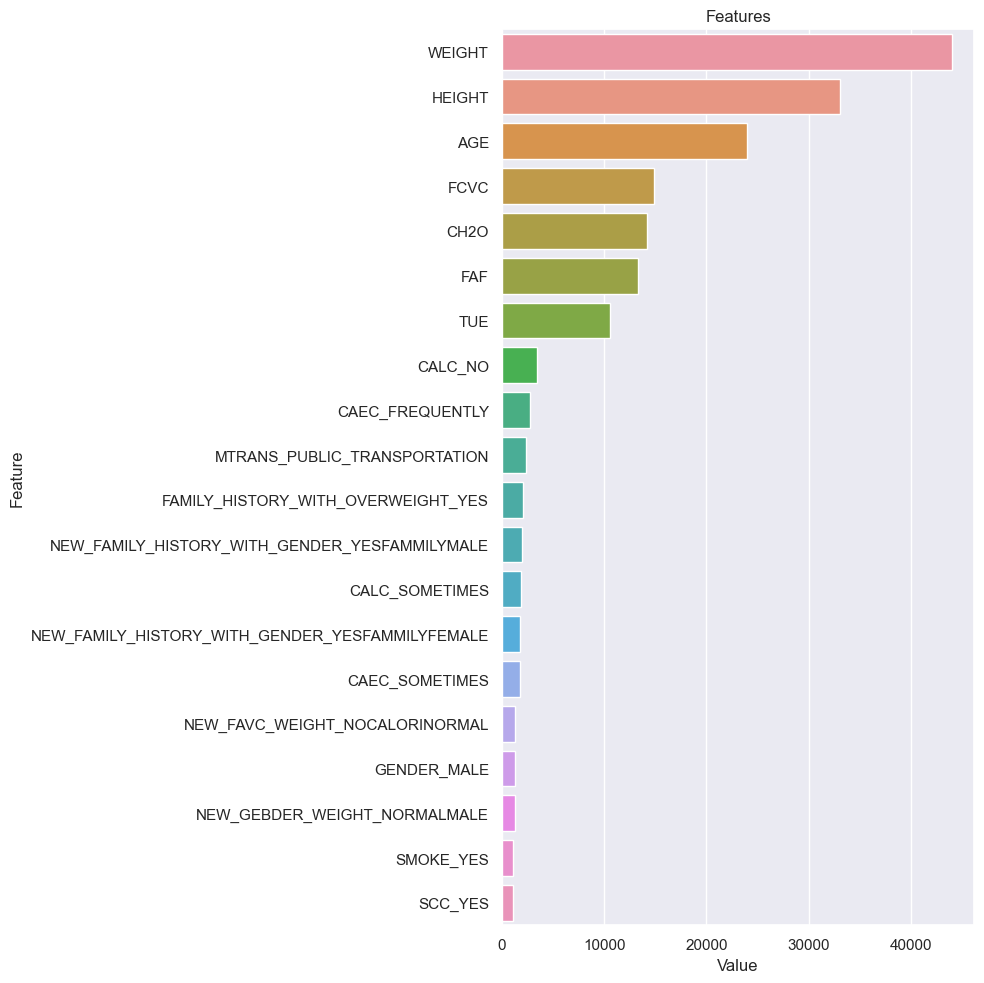

In [77]:
plot_importance(lgbm_final, X, num=20, save=False)

In [78]:
#############################################
# Validation Curve
#############################################


# val_curve_params function for validation curve
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model,
        X=X,
        y=y,
        param_name=param_name,
        param_range=param_range,
        scoring=scoring,
        cv=cv,
    )

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score, label="Training Score", color="b")

    plt.plot(param_range, mean_test_score, label="Validation Score", color="g")

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show(block=True)


lgbm_val_params = {
    "max_depth": np.random.randint(5, 50, 10),
    "max_features": [3, 5, 7, "auto", "sqrt"],
    "min_samples_split": np.random.randint(2, 50, 20),
    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)],
}

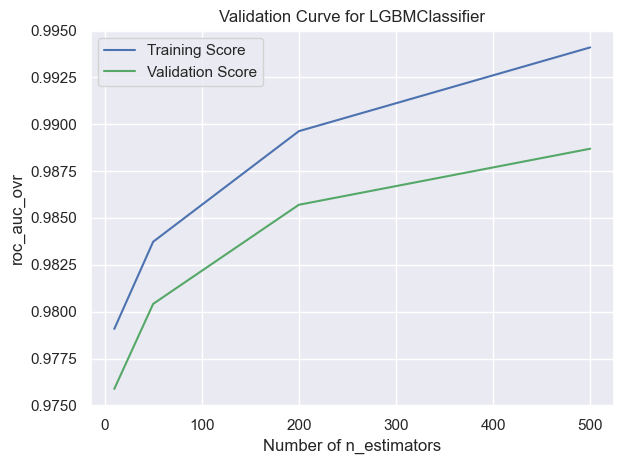

In [79]:
# validation curve for n_estimators
val_curve_params(
    lgbm_final,
    X,
    y,
    param_name="n_estimators",
    param_range=[10, 50, 200, 500],
    scoring="roc_auc_ovr",
    cv=5,
)